In [6]:
# --- Cell 1: Import Libraries ---
import pandas as pd
import os
import json
from azure.cosmos import CosmosClient, exceptions # For synchronous Cosmos DB client
from dotenv import load_dotenv
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Explicitly import numpy

# Azure ML SDK imports for deployment (COMMENTED OUT FOR LOCAL EXECUTION)
# from azureml.core import Workspace, Model, Environment
# from azureml.core.conda_dependencies import CondaDependencies # Used internally by Environment.from_conda_specification
# from azureml.core.model import InferenceConfig
# from azureml.core.webservice import AciWebservice, Webservice
# from azureml.core.authentication import InteractiveLoginAuthentication # For interactive login if needed

print("All required libraries imported successfully!")

All required libraries imported successfully!


In [7]:
import sys
print(sys.executable)
print(sys.version)
!pip freeze | grep azureml
!pip freeze | grep scikit-learn
!which python

/Users/praveenchalla/micromamba/envs/iot_ad_env/bin/python3.11
3.11.13 (main, Jun  5 2025, 08:21:08) [Clang 14.0.6 ]
scikit-learn==1.7.0
/Users/praveenchalla/micromamba/envs/iot_ad_env/bin/python


In [8]:
# --- Cell 2: Load Environment Variables & Initialize Cosmos DB Client ---
# Load environment variables from .env file (ensure .env is in the same directory as this notebook)
load_dotenv() 

# --- Cosmos DB Configuration ---
COSMOS_DB_URI = os.getenv("COSMOS_DB_URI")
COSMOS_DB_KEY = os.getenv("COSMOS_DB_KEY")
COSMOS_DB_DATABASE_ID = "iot-sensor-db"
COSMOS_DB_CONTAINER_ID = "anomalies"

# --- Initialize Cosmos DB client (synchronous version for batch query) ---
cosmos_client = None
try:
    if COSMOS_DB_URI and COSMOS_DB_KEY:
        cosmos_client = CosmosClient(COSMOS_DB_URI, credential=COSMOS_DB_KEY)
        database = cosmos_client.get_database_client(COSMOS_DB_DATABASE_ID)
        container = database.get_container_client(COSMOS_DB_CONTAINER_ID)
        print("Cosmos DB client and container initialized for batch query.")
    else:
        print("ERROR: Cosmos DB credentials not found. Cannot connect for batch query. Check .env file.")
except exceptions.CosmosResourceNotFoundError as e:
    print(f"ERROR: Cosmos DB resource not found: {e}. Please ensure database '{COSMOS_DB_DATABASE_ID}' and container '{COSMOS_DB_CONTAINER_ID}' exist and names are correct.")
except Exception as e:
    print(f"ERROR: Failed to initialize Cosmos DB client for batch query: {e}")


Cosmos DB client and container initialized for batch query.


In [10]:
# --- Cell 3: Query & Load Data for Training ---
# Define the query to get "normal" data for training.
# We'll fetch all sensor measurements (sensor_1 to sensor_21) and operational settings (setting_1 to setting_3).
# We'll query for units 1.0 to 5.0 and cycles <= 50, as these are typically considered healthy/normal.
# Ensure these match the fields you are actually storing in Cosmos DB.
query = """
SELECT c.unit_number, c.time_in_cycles, 
       c.setting_1, c.setting_2, c.setting_3,
       c.sensor_1, c.sensor_2, c.sensor_3, c.sensor_4, c.sensor_5, c.sensor_6, c.sensor_7, c.sensor_8, c.sensor_9, 
       c.sensor_10, c.sensor_11, c.sensor_12, c.sensor_13, c.sensor_14, c.sensor_15, c.sensor_16, c.sensor_17, 
       c.sensor_18, c.sensor_19, c.sensor_20, c.sensor_21
FROM c 
WHERE c.time_in_cycles <= 50 AND c.unit_number IN (1.0, 2.0, 3.0, 4.0, 5.0)
ORDER BY c.unit_number ASC, c.time_in_cycles ASC
"""

items = []
if 'container' in locals() and container is not None: # Check if container was successfully initialized
    try:
        # enable_cross_partition_query=True is needed for queries across multiple partition key values
        for item in container.query_items(query=query, enable_cross_partition_query=True):
            items.append(item)
        print(f"Retrieved {len(items)} records from Cosmos DB for training.")
    except Exception as e:
        print(f"ERROR: Error querying Cosmos DB: {e}")
else:
    print("ERROR: Cosmos DB container not available for querying. Check previous cell output.")

# Convert to Pandas DataFrame
if items:
    df_normal = pd.DataFrame(items)
    print(f"DataFrame loaded with shape: {df_normal.shape}")
    print("\nFirst 5 rows of the normal data:")
    display(df_normal.head()) 
    
    print("\nDataFrame Info (data types and non-null counts):")
    df_normal.info()
else:
    df_normal = pd.DataFrame()
    print("No data retrieved to create DataFrame. df_normal is empty.")


Retrieved 1629 records from Cosmos DB for training.
DataFrame loaded with shape: (1629, 26)

First 5 rows of the normal data:


,unit_number,time_in_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.7,1400.6,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392.0,2388.0,100.0,39.06,23.419
2,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.7,1400.6,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392.0,2388.0,100.0,39.06,23.419
3,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.7,1400.6,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392.0,2388.0,100.0,39.06,23.419
4,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.7,1400.6,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392.0,2388.0,100.0,39.06,23.419



DataFrame Info (data types and non-null counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1629 entries, 0 to 1628
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   unit_number     1629 non-null   int64  
 1   time_in_cycles  1629 non-null   int64  
 2   setting_1       1250 non-null   float64
 3   setting_2       1250 non-null   float64
 4   setting_3       1250 non-null   float64
 5   sensor_1        1250 non-null   float64
 6   sensor_2        1250 non-null   float64
 7   sensor_3        1250 non-null   float64
 8   sensor_4        1250 non-null   float64
 9   sensor_5        1250 non-null   float64
 10  sensor_6        1250 non-null   float64
 11  sensor_7        1250 non-null   float64
 12  sensor_8        1250 non-null   float64
 13  sensor_9        1250 non-null   float64
 14  sensor_10       1250 non-null   float64
 15  sensor_11       1250 non-null   float64
 16  sensor_12       1250 non-nul

In [11]:

# --- Cell 4: Feature Selection & Data Cleaning ---
# Identify feature columns (sensor measurements + operational settings)
# These names must exactly match the columns in your Cosmos DB documents and original data.
feature_cols = ['setting_1', 'setting_2', 'setting_3'] + \
               [f'sensor_{i}' for i in range(1, 22)] 

# Ensure all feature_cols exist in your DataFrame. This is critical for model consistency.
missing_cols = [col for col in feature_cols if col not in df_normal.columns]
if missing_cols:
    print(f"CRITICAL WARNING: Missing feature columns in DataFrame that are expected: {missing_cols}")
    print(f"This indicates an issue in stream_data.py or event_consumer.py. Please resolve before proceeding for best results.")
    # Filter feature_cols to only include those present to avoid errors.
    feature_cols = [col for col in feature_cols if col in df_normal.columns]
    print(f"Proceeding with available feature columns: {feature_cols}")

X_train_raw = df_normal[feature_cols].copy()

# Handle any potential NaNs (though with correct streaming, this should be minimal for NASA data)
# For this project, we'll drop rows with NaNs. For production, imputation or more robust handling is preferred.
if X_train_raw.isnull().sum().sum() > 0:
    print(f"WARNING: Found {X_train_raw.isnull().sum().sum()} NaN values in features. Dropping rows with NaNs.")
    X_train_raw.dropna(inplace=True)
    print(f"New training features DataFrame shape after dropping NaNs: {X_train_raw.shape}")

print(f"Raw training features DataFrame shape: {X_train_raw.shape}")
print("\nDescriptive statistics for raw training features:")
display(X_train_raw.describe())


New training features DataFrame shape after dropping NaNs: (1250, 24)
Raw training features DataFrame shape: (1250, 24)

Descriptive statistics for raw training features:


,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
count,1250.000000,1250.000000,1250.0,1250.00,1250.000000,1250.000000,1250.000000,1250.00,1250.000000,1250.000000,...,1250.000000,1250.00000,1250.000000,1250.000000,1250.00,1250.000000,1250.0,1250.0,1250.000000,1250.000000
mean,0.000151,0.000010,100.0,518.67,642.207200,1585.108880,1399.168680,14.62,21.609320,554.277280,...,522.183920,2388.03044,8137.967200,8.405414,0.03,391.728000,2388.0,100.0,38.992280,23.394433
std,0.002202,0.000309,0.0,0.00,0.347474,4.162739,4.460136,0.00,0.002518,0.493049,...,0.373593,0.04269,7.026562,0.021123,0.00,0.987317,0.0,0.0,0.111432,0.064124
min,-0.006400,-0.000500,100.0,518.67,641.270000,1574.800000,1387.500000,14.62,21.600000,552.530000,...,521.230000,2387.93000,8125.280000,8.344900,0.03,390.000000,2388.0,100.0,38.690000,23.200200
25%,-0.001300,-0.000200,100.0,518.67,641.990000,1582.190000,1396.050000,14.62,21.610000,553.970000,...,521.910000,2388.00000,8132.670000,8.390500,0.03,391.000000,2388.0,100.0,38.920000,23.350000
50%,0.000200,0.000000,100.0,518.67,642.180000,1584.745000,1399.130000,14.62,21.610000,554.310000,...,522.195000,2388.03000,8136.970000,8.407150,0.03,392.000000,2388.0,100.0,38.990000,23.400500
75%,0.001600,0.000300,100.0,518.67,642.440000,1588.190000,1401.900000,14.62,21.610000,554.640000,...,522.430000,2388.06000,8141.570000,8.420100,0.03,392.000000,2388.0,100.0,39.060000,23.441200
max,0.006300,0.000600,100.0,518.67,643.070000,1596.220000,1415.570000,14.62,21.610000,555.570000,...,523.070000,2388.13000,8156.040000,8.468400,0.03,395.000000,2388.0,100.0,39.240000,23.600500


In [12]:
# --- Cell 5: Data Scaling ---
# Initialize and fit the scaler on your raw training features.
# MinMaxScaler is suitable for anomaly detection as it preserves zero anomalies.
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)

print("Training data scaled successfully!")
print("Shape of scaled data:", X_train_scaled.shape)
print("\nFirst 5 rows of scaled data:")
print(X_train_scaled[:5])

# Store the feature column names used for scaling in the correct order.
# This list is absolutely CRUCIAL for real-time inference, as incoming data
# must be ordered identically before scaling and prediction.
scaled_feature_names = X_train_raw.columns.tolist() 
print(f"\nFeature names used for scaling (order matters): {scaled_feature_names}")


Training data scaled successfully!
Shape of scaled data: (1250, 24)

First 5 rows of scaled data:
[[0.4488189  0.09090909 0.         0.         0.30555556 0.69561158
  0.46669042 0.         1.         0.60197368 0.63636364 0.16176471
  0.         0.7012987  0.23369565 0.45       0.4336801  0.60404858
  0.         0.4        0.         0.         0.67272727 0.54659006]
 [0.4488189  0.09090909 0.         0.         0.30555556 0.69561158
  0.46669042 0.         1.         0.60197368 0.63636364 0.16176471
  0.         0.7012987  0.23369565 0.45       0.4336801  0.60404858
  0.         0.4        0.         0.         0.67272727 0.54659006]
 [0.4488189  0.09090909 0.         0.         0.30555556 0.69561158
  0.46669042 0.         1.         0.60197368 0.63636364 0.16176471
  0.         0.7012987  0.23369565 0.45       0.4336801  0.60404858
  0.         0.4        0.         0.         0.67272727 0.54659006]
 [0.4488189  0.09090909 0.         0.         0.30555556 0.69561158
  0.46669042 0.

Initializing Isolation Forest model...
Training Isolation Forest model on scaled normal data (X_train_scaled)...
Isolation Forest model trained successfully!

Predictions (first 20): [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Anomaly Scores (first 20): [0.10979509 0.10979509 0.10979509 0.10979509 0.10979509 0.08295176
 0.08295176 0.08295176 0.08295176 0.08295176 0.0979476  0.0979476
 0.0979476  0.0979476  0.0979476  0.08643854 0.08643854 0.08643854
 0.08643854 0.08643854]


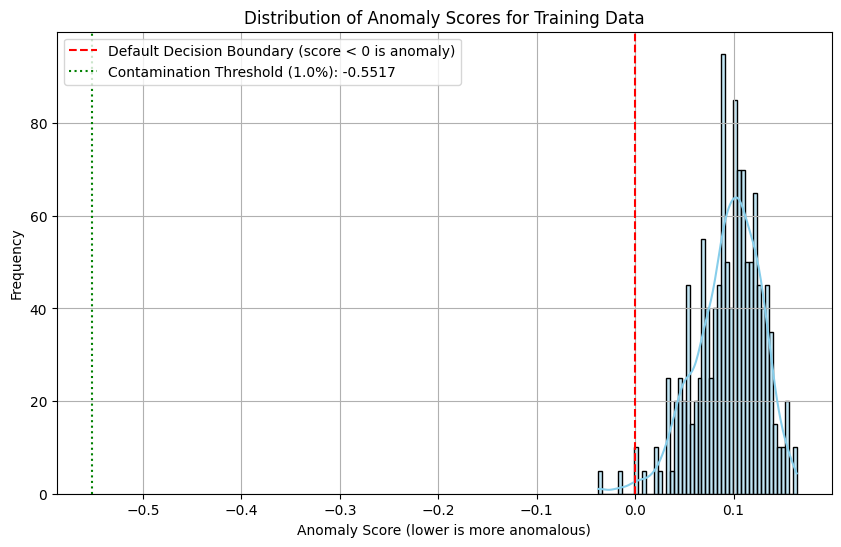

Minimum anomaly score: -0.0374
Maximum anomaly score: 0.1641
Mean anomaly score: 0.0943

Model's internal threshold (derived from contamination=0.01): -0.5517 (scores below this are classified as anomalies)


In [17]:
# --- Cell 6: Anomaly Detection Model Training & Evaluation ---
print("Initializing Isolation Forest model...")
# Isolation Forest is a good choice for unsupervised anomaly detection:
# - n_estimators: Number of isolation trees to build.
# - contamination: The expected proportion of outliers in the data. This helps the model
#                  determine its internal decision threshold. For training on primarily
#                  'normal' data, setting it to a small value (e.g., 0.01 for 1%) is common.
# - random_state: For reproducibility of results.
model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)

print("Training Isolation Forest model on scaled normal data (X_train_scaled)...")
# Fit the model. It learns what 'normal' data looks like.
model.fit(X_train_scaled)

print("Isolation Forest model trained successfully!")

# Predict anomalies (-1 for outlier, 1 for inlier) on the training data itself
predictions = model.predict(X_train_scaled)
anomaly_scores = model.decision_function(X_train_scaled) # Raw anomaly score (lower/more negative is more anomalous)

print("\nPredictions (first 20):", predictions[:20])
print("Anomaly Scores (first 20):", anomaly_scores[:20])

# Analyze the distribution of anomaly scores
plt.figure(figsize=(10, 6))
sns.histplot(anomaly_scores, bins=50, kde=True, color='skyblue')
plt.title('Distribution of Anomaly Scores for Training Data')
plt.xlabel('Anomaly Score (lower is more anomalous)')
plt.ylabel('Frequency')
plt.grid(True)
plt.axvline(x=0, color='red', linestyle='--', label='Default Decision Boundary (score < 0 is anomaly)')
plt.axvline(x=model.offset_, color='green', linestyle=':', label=f'Contamination Threshold ({model.contamination*100}%): {model.offset_:.4f}')
plt.legend()
plt.show()

print(f"Minimum anomaly score: {anomaly_scores.min():.4f}")
print(f"Maximum anomaly score: {anomaly_scores.max():.4f}")
print(f"Mean anomaly score: {anomaly_scores.mean():.4f}")

# The model's internal threshold is set based on the 'contamination' parameter.
# model.threshold_ is the raw score below which data is considered anomalous.
# model.offset_ is the value used to determine the `predict` output (-1 or 1).
print(f"\nModel's internal threshold (derived from contamination={model.contamination}): {model.offset_:.4f} (scores below this are classified as anomalies)")



In [15]:

# --- Cell 7: Save Model and Scaler ---
# Define a directory to save your model artifacts
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True) # Create the directory if it doesn't exist

model_path = os.path.join(MODEL_DIR, "anomaly_model.pkl")
scaler_path = os.path.join(MODEL_DIR, "scaler.pkl")
scaled_feature_names_path = os.path.join(MODEL_DIR, "scaled_feature_names.json")

# Save the trained model using joblib (recommended for scikit-learn models)
joblib.dump(model, model_path)
print(f"Anomaly detection model saved to: {model_path}")

# Save the fitted scaler. This is ESSENTIAL because new, incoming data
# for real-time inference MUST be scaled using the *exact same scaler*
# that was trained on your normal data.
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

# Save the list of feature names and their order. This is CRUCIAL for inference
# to ensure that incoming data columns are processed in the same order the
# model and scaler were trained on.
with open(scaled_feature_names_path, 'w') as f:
    json.dump(scaled_feature_names, f)
print(f"Scaled feature names saved to: {scaled_feature_names_path}")



Anomaly detection model saved to: models/anomaly_model.pkl
Scaler saved to: models/scaler.pkl
Scaled feature names saved to: models/scaled_feature_names.json


In [16]:
# --- Cell 8: Azure Machine Learning Model Deployment ---
# Replace placeholders with your actual Azure Subscription ID and AML Workspace Name.
# Your Resource Group is "iot-anomaly-rg".

# 1. Connect to your Azure ML Workspace
# It will first try to connect using config.json (generated by az ml workspace show).
# If that fails, it falls back to interactive login.
try:
    ws = Workspace.from_config() 
    print("Connected to Azure ML Workspace using config.json.")
except Exception:
    print("config.json not found or failed to connect. Authenticating directly...")
    
    # --- REPLACE THESE PLACEHOLDERS WITH YOUR ACTUAL AZURE ML WORKSPACE DETAILS ---
    subscription_id = "<Your_Subscription_Id>" # From Azure Portal -> AML Workspace Overview
    resource_group = "iot-anomaly-rg"        # Your resource group name
    workspace_name = "praveenchalla-iot-aml" # Your Azure ML Workspace name

    # Interactive login will open a browser window for authentication
    auth = InteractiveLoginAuthentication() 
    ws = Workspace(subscription_id=subscription_id,
                   resource_group=resource_group,
                   workspace_name=workspace_name,
                   auth=auth)
    print(f"Connected to Azure ML Workspace '{workspace_name}' directly.")
    
# --- IMPORTANT: Explicitly write config.json to the current directory ---
# This ensures that config.json is always created/updated in your project folder
# after a successful connection, making future runs smoother.
ws.write_config() 
print("config.json written to local directory for future use.")


# 2. Register the Model (including scaler and feature names)
model_name = "iot-anomaly-model" 

# Register the model and scaler files saved locally in the 'models' directory.
# Azure ML will create a unique version if you re-register with the same name.
model_registration = Model.register(workspace=ws,
                                    model_path=MODEL_DIR, # Points to the local directory containing model artifacts
                                    model_name=model_name,
                                    description="Isolation Forest Anomaly detection model for IoT turbofan engine sensors (NASA FD001)",
                                    tags={'area': 'predictive_maintenance', 'model_type': 'anomaly_detection', 'dataset': 'NASA_FD001'},
                                    model_framework=Model.Framework.SCIKITLEARN, # Use enum for framework
                                    model_framework_version=str(sklearn.__version__)) # Convert version to string

print(f"Model '{model_name}' registered successfully. Version: {model_registration.version}")


# 3. Create an Environment (defines Python dependencies for the deployed service)
# This environment is built into a Docker image by Azure ML.
env_name = "anomaly-detection-env"
# Environment.from_conda_specification uses your conda_env.yml file.
# This file must be in the same directory as this notebook.
env = Environment.from_conda_specification(name=env_name, file_path="conda_env.yml")
env.python.user_managed_dependencies = False # Let AML manage dependencies within the image
env.docker.enabled = True # Ensure Docker is enabled for the environment

print(f"Environment '{env_name}' created from conda_env.yml.")


# 4. Create an Inference Configuration (connects entry script and environment)
# The 'entry_script' is score.py, which defines init() and run().
# This file must be in the same directory as this notebook.
inference_config = InferenceConfig(entry_script="score.py",
                                   environment=env)
print("Inference configuration created.")


# 5. Define Deployment Configuration (specify compute type and resources for the endpoint)
# AciWebservice is suitable for quick, low-cost deployment for development/demo.
# For production, AksWebservice is used for higher scale/reliability.
aci_config = AciWebservice.deploy_configuration(cpu_cores=1, 
                                                memory_gb=1.5, # Increased memory slightly for robustness
                                                enable_app_insights=True, # Good for monitoring logs from deployed service
                                                auth_enabled=False # Set to True for production with API Key
                                                )
print("ACI deployment configuration created.")


# 6. Deploy the Model as a Web Service (Real-time Endpoint)
service_name = "iot-anomaly-service"
# The 'overwrite=True' allows you to re-run this cell to update the service
# if it already exists with the same name, without manual deletion first.
service = Model.deploy(workspace=ws,
                       name=service_name,
                       models=[model_registration], # Use the registered model version
                       inference_config=inference_config,
                       deployment_config=aci_config,
                       overwrite=True) 

print(f"\nDeploying service '{service_name}'...")
service.wait_for_deployment(show_output=True) # Wait for deployment to complete and show logs in notebook

print(f"\n--- Model Deployed Successfully! ---")
print(f"Scoring URI: {service.scoring_uri}")
print(f"Service state: {service.state}")

# If you set auth_enabled=True in aci_config, retrieve API key:
if aci_config.auth_enabled:
    api_key = service.get_keys()[0] # Get the primary key (index 0)
    print(f"API Key: {api_key}")
else:
    api_key = "N/A (Auth not enabled)" # Placeholder if auth is off


print("\n--- Next Steps ---")
print("1. Copy the 'Scoring URI' above.")
print("2. If authentication was enabled, copy the 'API Key'.")
print("3. Update your .env file in your main 'iot-anomaly-project' directory with:")
print(f"   ML_ENDPOINT_URL=\"{service.scoring_uri}\"")
print(f"   ML_ENDPOINT_KEY=\"{api_key}\"") 

print("\n4. Proceed to Phase 3.5: Integrate Deployed Model into event_consumer.py")
print("   (You'll open event_consumer.py and modify it to call this API endpoint.)")


# --- Optional Cell for Cleaning Up Deployed Endpoint (CRUCIAL FOR COST SAVINGS!) ---
# You MUST delete your ACI endpoint when not in use if you want to stay within your Azure credit budget.
# A deployed endpoint incurs costs even when idle.
# Run this cell ONLY when you are finished testing and want to delete the deployed service!
# service_to_delete_name = "iot-anomaly-service" # Ensure this matches your service name
# try:
#     service_to_delete = Webservice(workspace=ws, name=service_to_delete_name)
#     service_to_delete.delete() 
#     print(f"Service '{service_to_delete_name}' deleted.")
# except Exception as e:
#     print(f"Error deleting service {service_to_delete_name}: {e}")


config.json not found or failed to connect. Authenticating directly...


NameError: name 'InteractiveLoginAuthentication' is not defined